In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# -------------------------------
# 1. LOAD DATA
# -------------------------------
ng1 = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/Natural_Gas_Data prices.csv')
positions = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/Natural_Gas_Data positioning.csv')
inventory = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/inventory.csv')
hdd = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/HDD.csv')
cdd = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/CDD.csv')

# Convert Date columns to datetime and sort
for df in [ng1, positions, inventory, hdd, cdd]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    
# Drop rows with null Date in right-hand datasets
for df in [positions, inventory, hdd, cdd]:
    df.dropna(subset=['Date'], inplace=True)

# Process percentage columns in positions
pct_cols = ['Percent Producers', 'Percent Swaps', 'Percent Managed Money', 
            'Percent Other Reportable', 'Percent Non-reportable']
for col in pct_cols:
    if col in positions.columns:
        positions[col] = positions[col].astype(str).str.replace('%', '')
        positions[col] = pd.to_numeric(positions[col], errors='coerce')

# Merge using merge_asof with ng1 as the main dataset
data = ng1.copy()
data = pd.merge_asof(data, inventory, on='Date', direction='backward')
data = pd.merge_asof(data, positions, on='Date', direction='backward')
data = pd.merge_asof(data, hdd, on='Date', direction='backward')
data = pd.merge_asof(data, cdd, on='Date', direction='backward')
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

# -------------------------------
# 2. FEATURE ENGINEERING
# -------------------------------
data['Price_Change'] = data['NG1'].pct_change()           # Daily return on NG1
data['Spread'] = data['NG1'] - data['NG2']                 # Spread between NG1 and NG2

if 'Inventory (unit: BCF)' in data.columns:
    data['Inventory_Change'] = data['Inventory (unit: BCF)'].diff()  # Inventory change
if ('HDD' in data.columns) and ('CDD' in data.columns):
    data['Weather_Impact'] = data['HDD'] - data['CDD']      # Weather impact

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)


In [2]:

# -------------------------------
# 3. CALCULATE SIGNALS
# -------------------------------
# a) Spread Z-Score (20-day rolling window)
window = 20
data['Spread_Mean'] = data['Spread'].rolling(window).mean()
data['Spread_Std'] = data['Spread'].rolling(window).std()
data['Spread_Z'] = (data['Spread'] - data['Spread_Mean']) / data['Spread_Std']

# b) Inventory Signal: sign of inventory change (flip sign: increase = bearish)
data['Inventory_Signal'] = -np.sign(data['Inventory_Change'])

# c) Weather Signal: sign of (HDD - CDD); assume higher HDD is bullish
data['Weather_Signal'] = np.sign(data['Weather_Impact'])

# Composite Signal (original): average of signals; note the flip for spread for mean reversion
data['Composite_Signal'] = (-data['Spread_Z'] + data['Inventory_Signal'] + data['Weather_Signal']) / 3

# -------------------------------
# 4. VOLATILITY FILTER & POSITION SCALING
# -------------------------------
vol_window = 10
data['Volatility'] = data['Price_Change'].rolling(vol_window).std()
target_vol = 0.01  # target 1% daily volatility
data['Vol_Scale'] = target_vol / data['Volatility']
data['Vol_Scale'] = data['Vol_Scale'].clip(lower=0.5, upper=1.5)

# Generate raw signal adjusted by volatility scaling
threshold = 0.5
data['Raw_Signal'] = data['Composite_Signal'].apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))
data['Scaled_Signal'] = data['Raw_Signal'] * data['Vol_Scale']

# -------------------------------
# 5. BOLLINGER BANDS SIGNAL
# -------------------------------
bb_window = 20
data['BB_MA'] = data['NG1'].rolling(bb_window).mean()
data['BB_std'] = data['NG1'].rolling(bb_window).std()
data['BB_upper'] = data['BB_MA'] + 2 * data['BB_std']
data['BB_lower'] = data['BB_MA'] - 2 * data['BB_std']

def bb_signal(row):
    if row['NG1'] < row['BB_lower']:
        return 1    # Bullish signal if price is below lower band
    elif row['NG1'] > row['BB_upper']:
        return -1   # Bearish signal if price is above upper band
    else:
        return 0

data['BB_Signal'] = data.apply(bb_signal, axis=1)

# -------------------------------
# 6. COMBINED SIGNAL
# -------------------------------
# Combine the volatility-scaled composite signal and Bollinger Bands signal
data['Combined_Signal'] = (data['Scaled_Signal'] + data['BB_Signal']) / 2

# -------------------------------
# 7. DYNAMIC DRAWDOWN RISK MANAGEMENT WITH AUTOMATED REVERSAL
# -------------------------------
# We'll simulate a portfolio day-by-day. If the portfolio falls below target_drawdown of its peak,
# we either reduce exposure (set signal to 0) or, per your request, apply an automated reversal based on conditions.
portfolio_values = []
adjusted_signals = []
portfolio = 1.0
peak = 1.0
target_drawdown = 0.10 

# For reversal logic, we will flip the signal if a reversal is triggered and certain conditions based on prediction vs. price
reversal_mode = False
reversal_trigger = 0.90  # portfolio falls below 90% of peak
reversal_exit = 0.95     # exit reversal mode when portfolio recovers to 95% of peak

for i, row in data.iterrows():
    current_drawdown = (portfolio - peak) / peak
    if not reversal_mode and portfolio < reversal_trigger * peak:
        reversal_mode = True  
    elif reversal_mode and portfolio >= reversal_exit * peak:
        reversal_mode = False  

    if reversal_mode:
        adj_signal = -row['Combined_Signal']
    else:
        adj_signal = row['Combined_Signal']
    
    adjusted_signals.append(adj_signal)
    
    portfolio = portfolio * (1 + adj_signal * row['Price_Change'])
    if portfolio > peak:
        peak = portfolio
    portfolio_values.append(portfolio)

data['Adjusted_Signal'] = adjusted_signals
data['Dynamic_Portfolio'] = portfolio_values


In [3]:

# -------------------------------
# 8. PERFORMANCE METRICS
# -------------------------------
# Compute daily strategy returns using the adjusted signal (with 1-day lag)
data['Strategy_Return'] = data['Adjusted_Signal'].shift(1) * data['Price_Change']
data['Strategy_CumReturn'] = (1 + data['Strategy_Return']).cumprod()

daily_mean = data['Strategy_Return'].mean()
daily_std = data['Strategy_Return'].std()
sharpe_ratio = (daily_mean / daily_std) * np.sqrt(252) if daily_std != 0 else np.nan

downside_returns = data['Strategy_Return'][data['Strategy_Return'] < 0]
downside_std = np.std(downside_returns) if len(downside_returns) > 0 else 0
annualized_downside_std = downside_std * np.sqrt(252)
annualized_return = daily_mean * 252
sortino_ratio = annualized_return / annualized_downside_std if annualized_downside_std != 0 else np.nan

cum_return = data['Strategy_CumReturn']

print(f'Final Cumulative Return: {(cum_return.iloc[-1]-1)*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_ratio:.2f}')

Final Cumulative Return: 121696.22%
Sharpe Ratio: 1.97
Sortino Ratio: 2.16


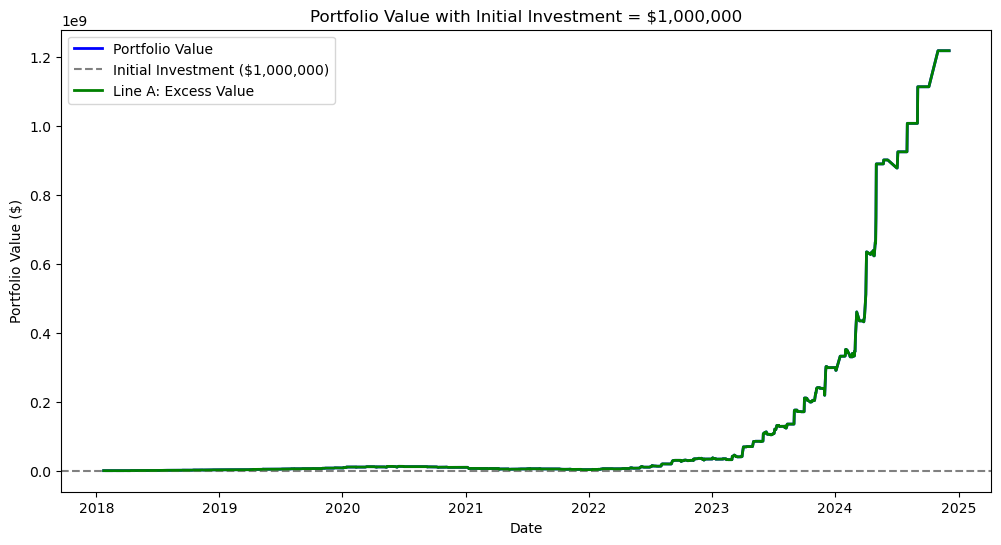

In [4]:
initial_investment = 1000000
data['Portfolio_Value'] = initial_investment * data['Strategy_CumReturn']
data['Excess_Value'] = data['Portfolio_Value'] - initial_investment

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Portfolio_Value'], label='Portfolio Value', color='blue', linewidth=2)
plt.axhline(initial_investment, color='gray', linestyle='--', label='Initial Investment ($1,000,000)')
plt.plot(data['Date'], data['Excess_Value'] + initial_investment, label='Line A: Excess Value', color='green', linewidth=2)

plt.title('Portfolio Value with Initial Investment = $1,000,000')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

In [5]:
final_portfolio_value = data['Portfolio_Value'].iloc[-1]
print("Final Portfolio Value: ${:,.2f}".format(final_portfolio_value))


Final Portfolio Value: $1,217,962,156.06
